## Analytic Distributions

In this notebook, we will model some empirical distributions from the Austin Bikeshare dataset using analytic distributions. We will apply different transformations and visualizations to determine whether the exponential, normal, log-normal, or pareto distributions fit our data.

We will also review some of the exercises from chapter 5 of ThinkStats2.

In [2]:
import math

import scipy.stats
import random
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()

import thinkplot
import thinkstats2

%matplotlib inline

### Modeling Austin BikeShare Data

#### Read in data and do some cleaning

In [3]:
# read in data from a csv file
df = pd.read_csv('../Data/austin_bikeshare_trips.csv')

# Remove any trip with 0 minute duration
df = df[df['duration_minutes'] > 0]

# Reset the integer based index of the DataFrame
df.reset_index(drop=True, inplace=True)

greater_than_2_hours = df[df['duration_minutes'] > 120]
frac_of_dataset = 100 * len(greater_than_2_hours) / len(df)

# Remove any trip lasting longer than 2 hours
df = df[df['duration_minutes'] <= 120]

# Reset the integer based index of the DataFrame
df.reset_index(drop=True, inplace=True)

Let's examine the **duration_minutes** field of the DataFrame and see if we can model it with an analytic distribution. Any ideas what distribution might work here? Let's plot the CDF first to see if we can recognize any shapes.

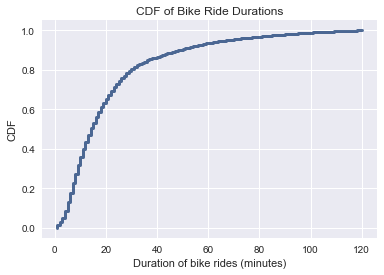

In [4]:
cdf = thinkstats2.Cdf(df['duration_minutes'])

thinkplot.Cdf(cdf)
thinkplot.Config(title='CDF of Bike Ride Durations', 
                 xlabel='Duration of bike rides (minutes)', ylabel='CDF')

This empirical CDF has the shape characteristic of an exponential distribution. 

In order to determine if the exponential distribution is a good model, let's plot the complementary CDF on a log(y) scale.

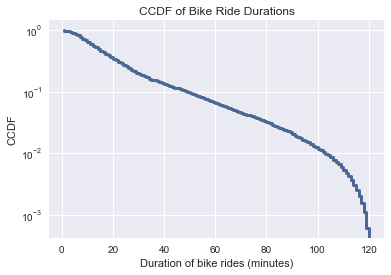

In [5]:
thinkplot.Cdf(cdf, complement=True)
thinkplot.Config(title='CCDF of Bike Ride Durations', 
                 xlabel='Duration of bike rides (minutes)',
                 ylabel='CCDF', yscale='log')

The CCDF does seem be linear up until the 100 minute mark. Hence, we can conclude that the exponential distribution models out data fairly well. Let's plot the CDF of a theoretical exponential distribution alongside our data to see how similaer the CDFs look.

In order to do this, we will have to set the parameter $\lambda$. The parameter can be interpreted as a rate, the number of events that occur, on average, in a unit of time. Since the mean of an exponential distribution is $\dfrac{1}{\lambda}$, we can easily calculate the parameter from the data.

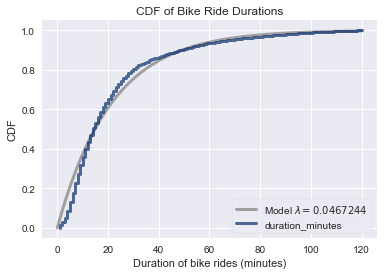

In [6]:
# Generate an exponential distribution with lambda = 1 / mean(df[duration_minutes])

lam = 1 / df['duration_minutes'].mean()

xs, ps = thinkstats2.RenderExpoCdf(lam, 0, 120)
label = r'Model $\lambda=%g$' % lam
thinkplot.Plot(xs, ps, label=label, color='grey')

thinkplot.Cdf(cdf, label='duration_minutes')
thinkplot.Config(title='CDF of Bike Ride Durations', 
                 xlabel='Duration of bike rides (minutes)', ylabel='CDF')

The exponential distribution seems to fit the data fairly well.

What about modeling the number of bike trips per day? Again, let's start by plotting the CDF of the number of bike trips per day and see if we can recognize the shape of any CDF we're familiar with.

In [7]:
df['start_time'] = pd.to_datetime(df['start_time'])
df['start_date'] = df['start_time'].apply(lambda t: t.date())

# Count the number of trips that start by day
daily_counts = df['start_date'].value_counts()

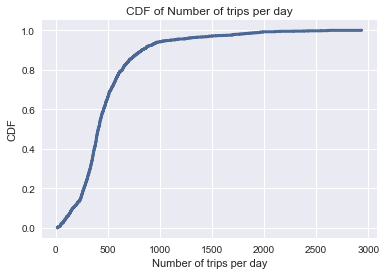

In [8]:
cdf = thinkstats2.Cdf(daily_counts)

thinkplot.Cdf(cdf)
thinkplot.Config(title='CDF of Number of trips per day', 
                 xlabel='Number of trips per day', ylabel='CDF')

Hmm, it's not exactly clear. We can make out a bit of a sigmoid shape, but we also see what looks like an exponential distribution. Let's go through the tests to identify each of the distributions.

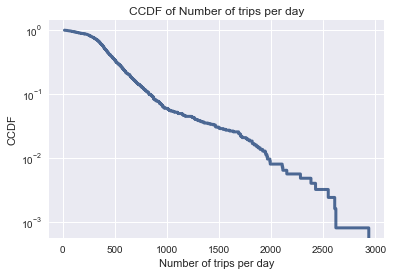

In [10]:
# Does an exponential distribution model our data well?
thinkplot.Cdf(cdf, complement=True)

thinkplot.Config(title='CCDF of Number of trips per day', 
                 xlabel='Number of trips per day',
                 ylabel='CCDF', yscale='log')

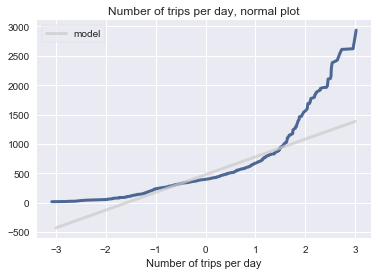

In [11]:
# Does an Gaussian distribution model our data well?

xs, ys = thinkstats2.NormalProbability(daily_counts)
thinkplot.Plot(xs, ys)

mean, var = thinkstats2.TrimmedMeanVar(daily_counts, p=0.01)
std = np.sqrt(var)

xs = [-3, 3]
xs, ys = thinkstats2.FitLine(xs, mean, std)
thinkplot.Plot(xs, ys, color='0.8', label='model')

thinkplot.Config(title='Number of trips per day, normal plot', 
                 xlabel='Number of trips per day')

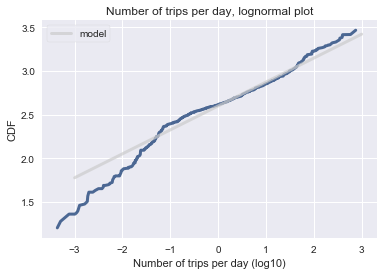

In [12]:
# Does a log normal distribution model our data well?

xs, ys = thinkstats2.NormalProbability(np.log10(daily_counts))
thinkplot.Plot(xs, ys)

mean, var = thinkstats2.TrimmedMeanVar(np.log10(daily_counts), p=0.01)
std = np.sqrt(var)

xs = [-3, 3]
xs, ys = thinkstats2.FitLine(xs, mean, std)
thinkplot.Plot(xs, ys, color='0.8', label='model')

thinkplot.Config(title='Number of trips per day, lognormal plot', 
                 xlabel='Number of trips per day (log10)',
                 ylabel='CDF')

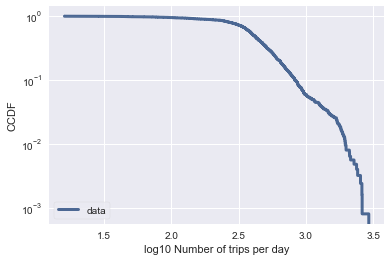

In [13]:
# Does a Pareto distribution model our data well?

cdf_log = thinkstats2.Cdf(np.log10(daily_counts), label='data')
thinkplot.Cdf(cdf_log, complement=True) 

thinkplot.Config(xlabel='log10 Number of trips per day',
                 ylabel='CCDF',
                 yscale='log', loc='lower left')

## Analytic Distributions

In order to get a better feel for analytic distributions, we will go through some of the exercises listed at the end of chapter 5.

### 5.1 Normal Distribution

**Exercise:** In the BRFSS (see Section 5.4), the distribution of heights is roughly normal with parameters µ = 178 cm and σ = 7.7 cm for men, and µ = 163 cm and σ = 7.3 cm for women.

In order to join Blue Man Group, you have to be male between 5’10” and 6’1” (see http://bluemancasting.com). What percentage of the U.S. male population is in this range? Hint: use `scipy.stats.norm.cdf`.

In [14]:
mu = 178
sigma = 7.7
dist = scipy.stats.norm(loc=mu, scale=sigma)
type(dist)

scipy.stats._distn_infrastructure.rv_frozen

In [15]:
def inch_to_cm(ft=0, inch=0):
    total_inch = ft * 12 + inch
    return total_inch * 2.54

In [16]:
100 * (dist.cdf(inch_to_cm(6, 1)) - dist.cdf(inch_to_cm(5, 10)))

34.274683763147458

### 5.2 Pareto Distribution

**Exercise:** To get a feel for the Pareto distribution, let’s see how different the world would be if the distribution of human height were Pareto. With the parameters xm = 1 m and α = 1.7, we get a distribution with a reasonable minimum, 1 m, and median, 1.5 m.

Plot this distribution. What is the mean human height in Pareto world? What fraction of the population is shorter than the mean? If there are 7 billion people in Pareto world, how many do we expect to be taller than 1 km? How tall do we expect the tallest person to be?

`scipy.stats.pareto` represents a pareto distribution.  In Pareto world, the distribution of human heights has parameters alpha=1.7 and xmin=1 meter.  So the shortest person is 100 cm and the median is 150.

In [17]:
def meters_to_feet(meters):
    return meters * 3.28

In [18]:
alpha = 1.7
xmin = 1       # meter
dist = scipy.stats.pareto(b=alpha, scale=xmin)

print('Median: {} ft or {} meters'.format(meters_to_feet(dist.median()), dist.median()))

Median: 4.93117382464786 ft or 1.5034066538560549 meters


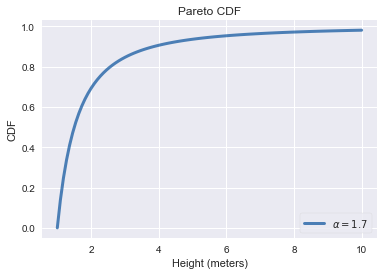

In [19]:
thinkplot.PrePlot(1)

xs, ps = thinkstats2.RenderParetoCdf(xmin, alpha, 0, 10.0, n=100) 
thinkplot.Plot(xs, ps, label=r'$\alpha=%g$' % alpha)
    
thinkplot.Config(title='Pareto CDF', xlabel='Height (meters)',
                 ylabel='CDF', loc='lower right')

In [20]:
print('Mean human height: {} ft or {} meters'.format(meters_to_feet(dist.mean()), dist.mean()))

Mean human height: 7.965714285714286 ft or 2.428571428571429 meters


In [21]:
print('Fraction of population shorter than the mean: ', dist.cdf(dist.mean()))

Fraction of population shorter than the mean:  0.778739697565


In [22]:
print('We expect {} people to be taller than 1 km'.format((1 - dist.cdf(1000)) * 7e9))

We expect 55602.976430479954 people to be taller than 1 km


### 5.3 Weibull Distribution

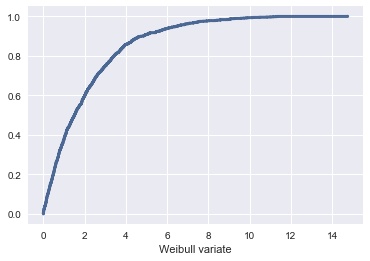

In [23]:
sample = [random.weibullvariate(2, 1) for _ in range(1000)]
cdf = thinkstats2.Cdf(sample)
thinkplot.Cdf(cdf)
thinkplot.Config(xlabel='Weibull variate')

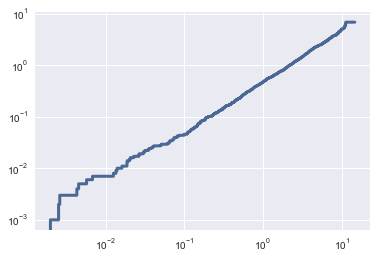

In [24]:
xs, ps = cdf.Render()

xs = np.asarray(xs)
ps = np.asarray(ps)

xs = xs[:-1]
ps = ps[:-1]
ps = [-math.log(1.0-p) for p in ps]

thinkplot.Plot(xs, ps)
thinkplot.Config(yscale='log', loc='lower left', xscale='log')

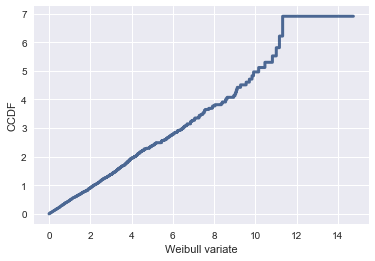

In [25]:
thinkplot.Cdf(cdf, transform='weibull')
thinkplot.Config(xlabel='Weibull variate', ylabel='CCDF')

## 5.4

**Exercise:** For small values of `n`, we don’t expect an empirical distribution to fit an analytic distribution exactly. One way to evaluate the quality of fit is to generate a sample from an analytic distribution and see how well it matches the data.

For example, in Section 5.1 we plotted the distribution of time between births and saw that it is approximately exponential. But the distribution is based on only 44 data points. To see whether the data might have come from an exponential distribution, generate 44 values from an exponential distribution with the same mean as the data, about 33 minutes between births.

Plot the distribution of the random values and compare it to the actual distribution. You can use random.expovariate to generate the values.

In [26]:
import analytic

df = analytic.ReadBabyBoom()
diffs = df.minutes.diff()
cdf = thinkstats2.Cdf(diffs, label='actual')

n = len(diffs)
lam = 44.0 / 24 / 60
sample = [random.expovariate(lam) for _ in range(n)]

1/lam, np.mean(sample)

(32.72727272727273, 33.319980356259386)

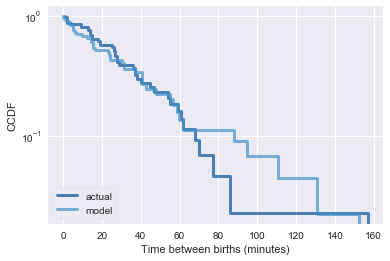

In [27]:
# Solution

model = thinkstats2.Cdf(sample, label='model')
    
thinkplot.PrePlot(2)
thinkplot.Cdfs([cdf, model], complement=True)
thinkplot.Config(xlabel='Time between births (minutes)',
                ylabel='CCDF',
                yscale='log')


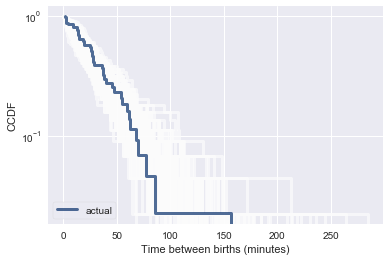

In [29]:
# Solution

# If you plot distributions for a large number of samples, you get a sense
# of how much random variation to expect.  In this case, the data fall within
# the range we expect, so there is no compelling reason to think it is
# not exponential.

for i in range(100):
    sample = [random.expovariate(lam) for _ in range(n)]
    thinkplot.Cdf(thinkstats2.Cdf(sample), complement=True, color='0.99')
    
thinkplot.Cdf(cdf, complement=True)
thinkplot.Config(xlabel='Time between births (minutes)',
                ylabel='CCDF',
                yscale='log')